In [30]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import dotenv_values
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from config import get_connection
from data.db import execute_sql
from data.notifcation_preparation import prepare_dataset, flat_notifications_from_sql
from data.preprocessing import DataPreprocessor

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

In [32]:
LOCAL_DATA_PATH = os.path.join('..', 'data', 'sample_notifications_data.parquet')
LOCAL_DATA_MODE = True

def load_dataset(data_path=None, conf_path="../.env") -> pd.DataFrame:
    if not data_path:
        print("Reading from db")
        conf = dotenv_values(conf_path)
        conn = get_connection(conf)
        notifications = execute_sql(conn, "select * from notifications order by id")
        raw_flat_data = prepare_dataset(flat_notifications_from_sql(notifications))
        data_preprocessor = DataPreprocessor(raw_flat_data, True)
        return data_preprocessor.provide_ready_df()
    else:
        print("Reading from local file")
        return pd.read_parquet(data_path)

In [33]:
df = load_dataset(LOCAL_DATA_PATH)

Reading from local file


In [27]:
#xg = load_dataset()
#xg.to_parquet(LOCAL_DATA_PATH)

In [28]:
# from data.scalers import min_max_scaler, standard_scaler
# df_norm = min_max_scaler(df)
# df_std= standard_scaler(df)

In [34]:
from verta import Client
client = Client("http://localhost:3333")

proj = client.set_project("Trading Singals")
expt = client.set_experiment("Extra Trees")

connection successfully established
got existing Project: Trading Singals
got existing Experiment: Extra Trees


In [35]:
label_cols = ['label_up_return', 'label_down_return']
x = df.drop(label_cols, axis=1)
y_up = df['label_up_return']
y_down = df['label_down_return']

In [36]:
x.shape

(52388, 673)

In [37]:
from model_factory import ModelFactory
_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()

2022-07-17 10:16:27,604 - root - INFO - Creating label column up_20_return with threshold of 20
2022-07-17 10:16:27,607 - root - INFO - label_20_up
0              43945
1               8443
dtype: int64


label_20_up
0              43945
1               8443
dtype: int64

In [38]:
def train(clf, x_train, y_train):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    return score

In [39]:
y_up_class.shape

(52388, 1)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y_up_class, test_size=0.1)

In [12]:
algos = {
    "Nearest_Neighbors": KNeighborsClassifier(3),
     #"Linear_SVM": SVC(kernel="linear", C=0.025),
     #"Polynomial_SVM": SVC(kernel="poly", degree=3, C=0.025),
     #"RBF_SVM": SVC(kernel="rbf", C=1, gamma=2),
     #"Gaussian_Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
     "Gradient_Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
     "Decision_Tree": DecisionTreeClassifier(max_depth=5),
     "Extra_Trees": ExtraTreesClassifier(n_estimators=10, min_samples_split=2), 
     "Random_Forest": RandomForestClassifier(max_depth=5, n_estimators=100), 
     "Neural_Net": MLPClassifier(alpha=1, max_iter=1000), 
     "AdaBoost": AdaBoostClassifier(n_estimators=100),
     "Naive_Bayes": GaussianNB(),
     "QDA": QuadraticDiscriminantAnalysis(),
     "SGD": SGDClassifier(loss="hinge", penalty="l2")
}


In [13]:
scores = []
models = []
result = {}

In [16]:
def train_gen(algos_dict):
    for name, clf in algos_dict.items():
        print(f"Training {name} model")
        score = train(clf, x_train, y_train)
        yield name, score, clf
check_list = ["Nearest_Neighbors", 
              "Gradient_Boosting", 
              "Extra_Trees",
              "Random_Forest",
              "Neural_Net",
              "AdaBoost",
              "Naive_Bayes"
              ]
for name, score, model in train_gen({k: v for k, v in algos.items() if k in check_list}):
    result[name] = model
    scores.append(score)
    models.append(model)

Training Nearest_Neighbors model
Training Gradient_Boosting model
Training Extra_Trees model
Training Random_Forest model
Training Neural_Net model
Training AdaBoost model
Training Naive_Bayes model


C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [17]:
df = pd.DataFrame()
df['name'] = check_list
df['score'] = scores

df

,name,score
0,Nearest_Neighbors,0.875740
1,Gradient_Boosting,0.884902
2,Extra_Trees,0.936247
3,Random_Forest,0.841000
4,Neural_Net,0.751098
5,AdaBoost,0.838710
6,Naive_Bayes,0.164344


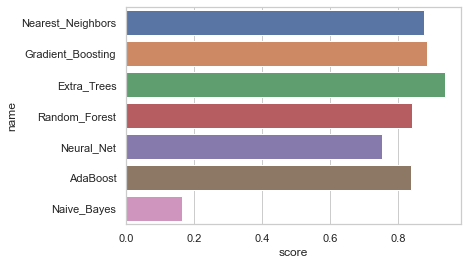

In [18]:
sns.set(style="whitegrid")

ax = sns.barplot(y="name", x="score", data=df)

In [41]:
def train_eval_model(x_train, x_test, y_train, y_test, model, name, thresh=20):
    run = client.set_experiment_run(name)
    print(f"Training model {name}")
    score = train(model, x_train, y_train)
    print(f"Score {score}")
    run.log_metric('score', score)
    print(f"Evaluating model {name}")
    run.log_artifact('model', a1)
    # Make predictions for the test UP set
    y_up_predictions = model.predict(x_test)
    # View accuracy score

    acc = accuracy_score(y_test, y_up_predictions)
    run.log_metric('accuracy', acc)
    print(acc)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    run.log_metric('auc', auc)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_test, y_up_predictions)
    print(matrix)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = [f'Higher than {thresh}%', f'Lower Than {thresh}%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_up_predictions))
    

In [23]:
models_dict = {}
def name_model(prefix, pars_dict):
    return f"{prefix} {'['.join(f'{k}_{v}' for k, v in pars_dict.items())}"

created new ExperimentRun: Lola n_estimators_60[min_samples_split_5[max_features_log2
Training model Lola n_estimators_60[min_samples_split_5[max_features_log2
Score 0.9251765604122925
Evaluating model Lola n_estimators_60[min_samples_split_5[max_features_log2
upload complete (model)
0.9251765604122925
[[4316   46]
 [ 346  531]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4362
           1       0.92      0.61      0.73       877

    accuracy                           0.93      5239
   macro avg       0.92      0.80      0.84      5239
weighted avg       0.92      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


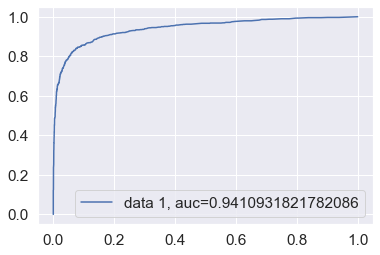

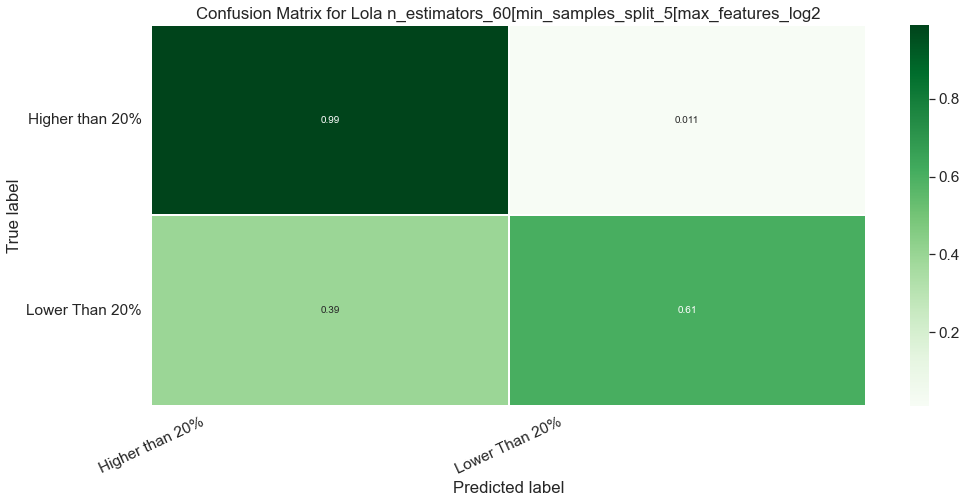

<AxesSubplot:>

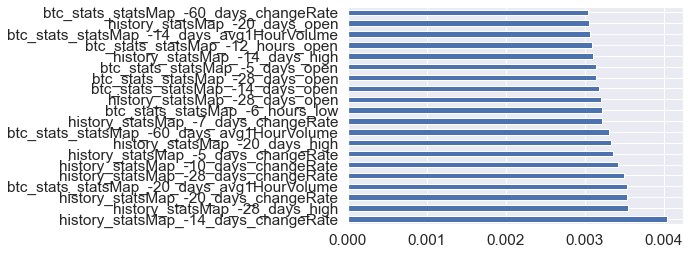

In [69]:
pars = {"n_estimators": 60,
"min_samples_split": 5,
"max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

feat_importances = pd.Series(a1.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

created new ExperimentRun: Lola n_estimators_60[min_samples_split_5[max_features_sqrt
Training model Lola n_estimators_60[min_samples_split_5[max_features_sqrt
Score 0.9331933575109754
Evaluating model Lola n_estimators_60[min_samples_split_5[max_features_sqrt
upload complete (model)
0.9331933575109754
[[4306   56]
 [ 294  583]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4362
           1       0.91      0.66      0.77       877

    accuracy                           0.93      5239
   macro avg       0.92      0.83      0.87      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


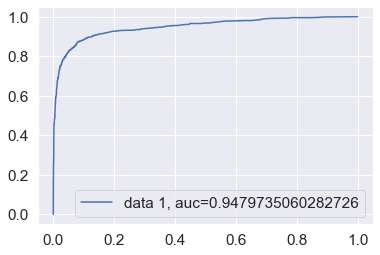

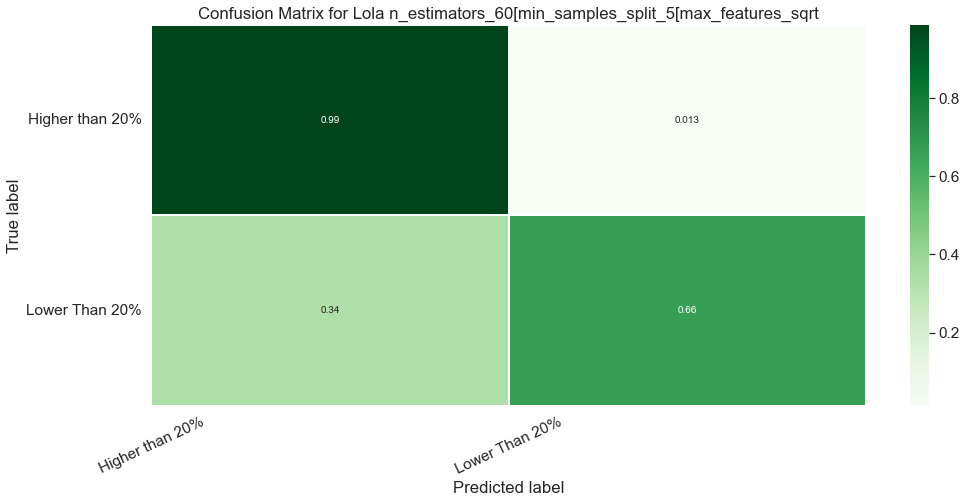

In [70]:
pars = {"n_estimators": 60,
 "min_samples_split": 5,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_50[min_samples_split_2[max_features_sqrt
Score 0.9410192784882612
Evaluating model Lola n_estimators_50[min_samples_split_2[max_features_sqrt
0.9410192784882612
[[4351   53]
 [ 256  579]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4404
           1       0.92      0.69      0.79       835

    accuracy                           0.94      5239
   macro avg       0.93      0.84      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


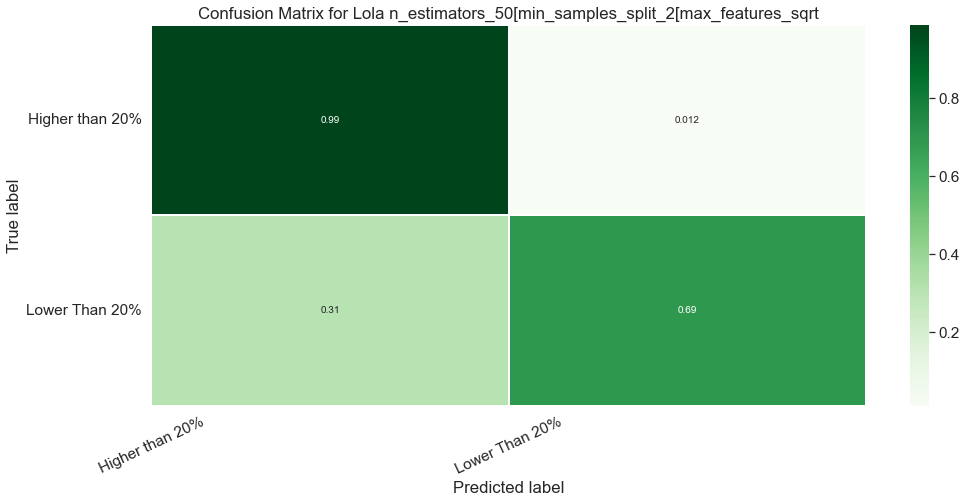

In [26]:
pars = {"n_estimators": 50,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_500[min_samples_split_2[max_features_sqrt
Score 0.9429280397022333
Evaluating model Lola n_estimators_500[min_samples_split_2[max_features_sqrt
0.9429280397022333
[[4354   50]
 [ 249  586]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.92      0.70      0.80       835

    accuracy                           0.94      5239
   macro avg       0.93      0.85      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


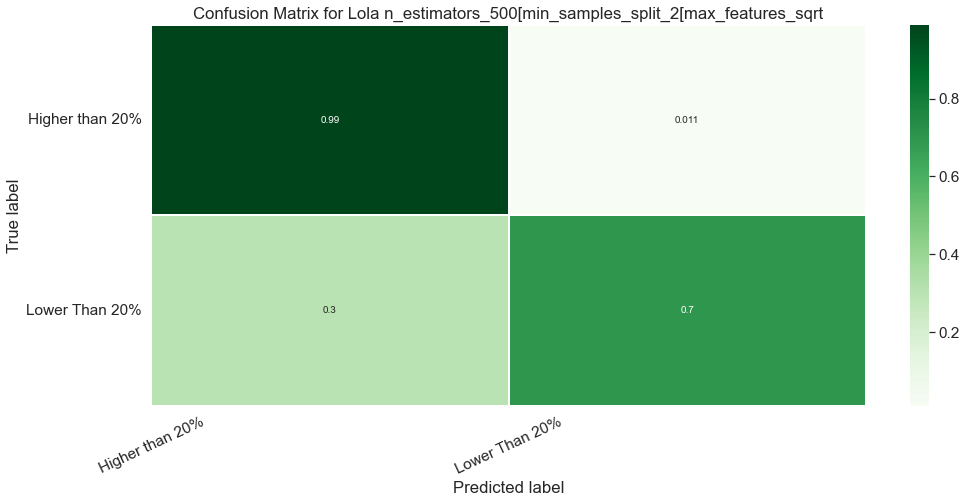

In [27]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_1212[min_samples_split_87[max_features_log2
Score 0.8461538461538461
Evaluating model Lola n_estimators_1212[min_samples_split_87[max_features_log2
0.8461538461538461
[[4397    7]
 [ 799   36]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4404
           1       0.84      0.04      0.08       835

    accuracy                           0.85      5239
   macro avg       0.84      0.52      0.50      5239
weighted avg       0.84      0.85      0.78      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


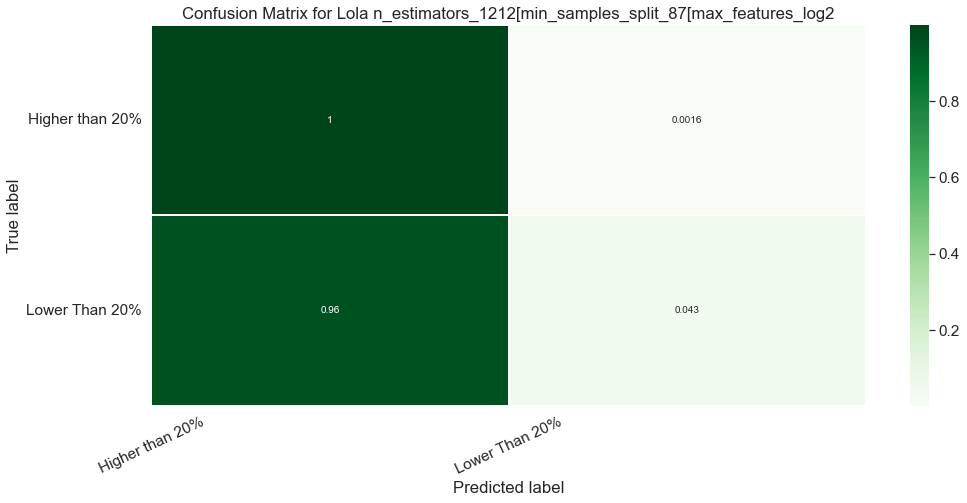

In [30]:
pars = {"n_estimators": 1212,
 "min_samples_split": 87,
 "max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_777[min_samples_split_6[max_features_log2
Score 0.9314754724184005
Evaluating model Lola n_estimators_777[min_samples_split_6[max_features_log2
0.9314754724184005
[[4373   31]
 [ 328  507]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4404
           1       0.94      0.61      0.74       835

    accuracy                           0.93      5239
   macro avg       0.94      0.80      0.85      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


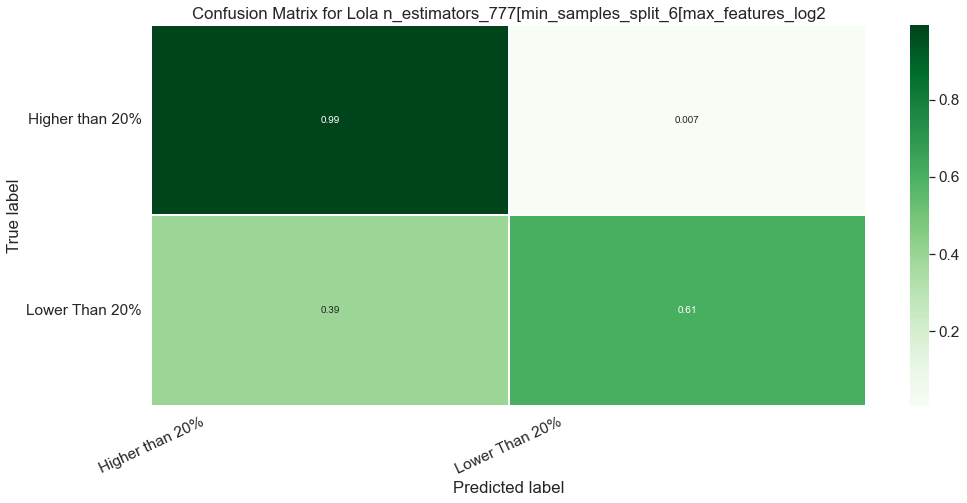

In [31]:
pars = {"n_estimators": 777,
 "min_samples_split": 6,
 "max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_100[min_samples_split_2[max_features_sqrt
Score 0.9414010307310555
Evaluating model Lola n_estimators_100[min_samples_split_2[max_features_sqrt
0.9414010307310555
[[4356   48]
 [ 259  576]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4404
           1       0.92      0.69      0.79       835

    accuracy                           0.94      5239
   macro avg       0.93      0.84      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


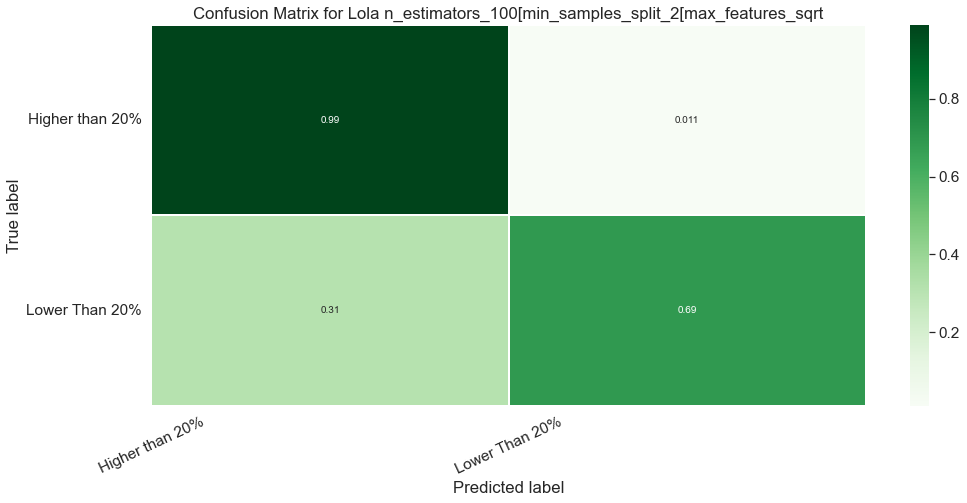

In [32]:
pars = {"n_estimators": 100,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_50[min_samples_split_2[min_samples_leaf_3[max_features_sqrt
Score 0.9265126932620729
Evaluating model Lola n_estimators_50[min_samples_split_2[min_samples_leaf_3[max_features_sqrt
0.9265126932620729
[[4367   37]
 [ 348  487]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4404
           1       0.93      0.58      0.72       835

    accuracy                           0.93      5239
   macro avg       0.93      0.79      0.84      5239
weighted avg       0.93      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


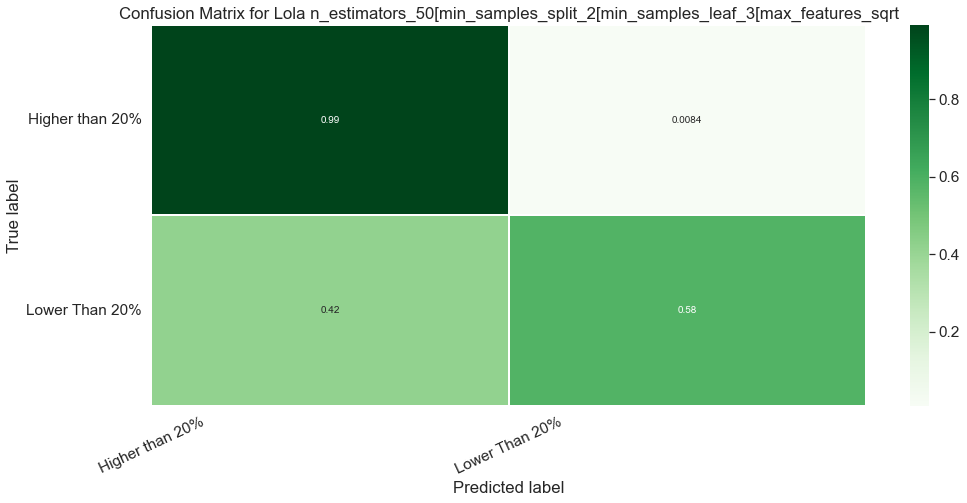

In [33]:
pars = {"n_estimators": 50,
 "min_samples_split": 2,
 "min_samples_leaf": 3,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_200[min_samples_split_3[min_samples_leaf_1[max_features_sqrt
Score 0.942737163580836
Evaluating model Lola n_estimators_200[min_samples_split_3[min_samples_leaf_1[max_features_sqrt
0.942737163580836
[[4356   48]
 [ 252  583]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.92      0.70      0.80       835

    accuracy                           0.94      5239
   macro avg       0.93      0.84      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


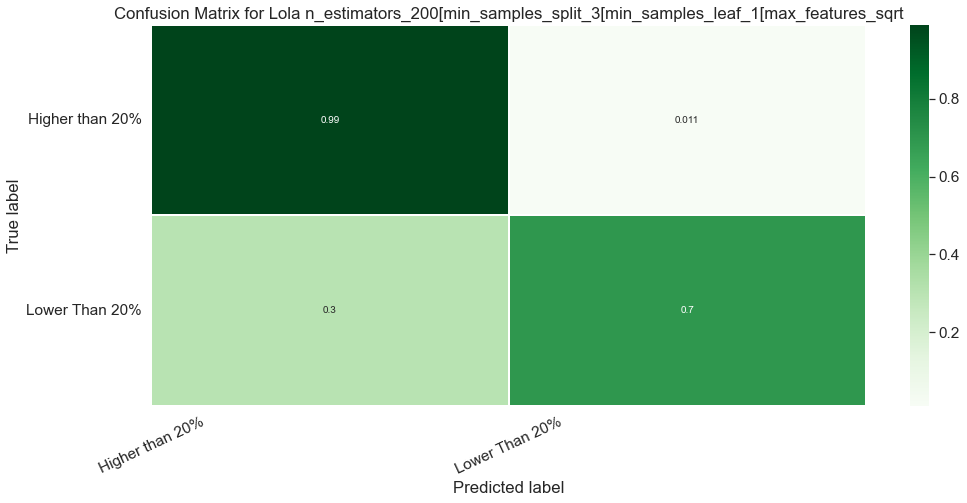

In [34]:
pars = {"n_estimators": 200,
 "min_samples_split": 3,
 "min_samples_leaf": 1,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")



Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
Score 0.9459820576445886
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
0.9459820576445886
[[4371   33]
 [ 250  585]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.95      0.70      0.81       835

    accuracy                           0.95      5239
   macro avg       0.95      0.85      0.89      5239
weighted avg       0.95      0.95      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


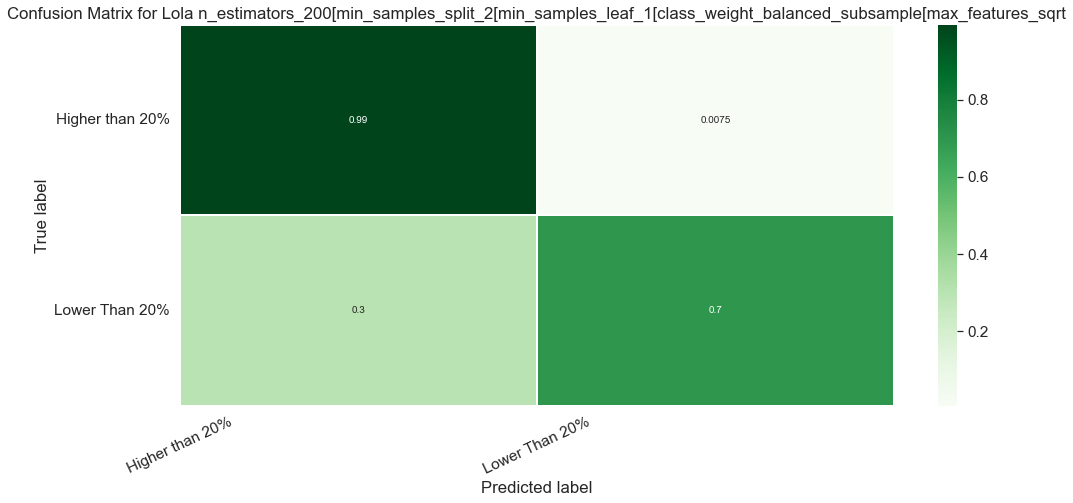

In [35]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")





Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.2, 1: 0.8}[max_features_sqrt
Score 0.9444550486734109
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.2, 1: 0.8}[max_features_sqrt
0.9444550486734109
[[4365   39]
 [ 252  583]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.94      0.70      0.80       835

    accuracy                           0.94      5239
   macro avg       0.94      0.84      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


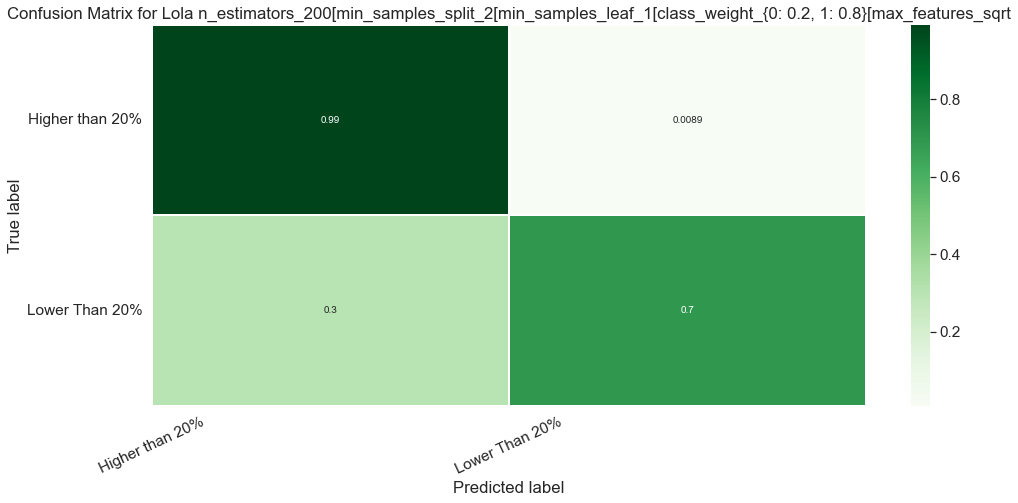

In [36]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.2, 1:.8},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")



Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.3, 1: 0.7}[max_features_sqrt
Score 0.9444550486734109
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.3, 1: 0.7}[max_features_sqrt
0.9444550486734109
[[4362   42]
 [ 249  586]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.93      0.70      0.80       835

    accuracy                           0.94      5239
   macro avg       0.94      0.85      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


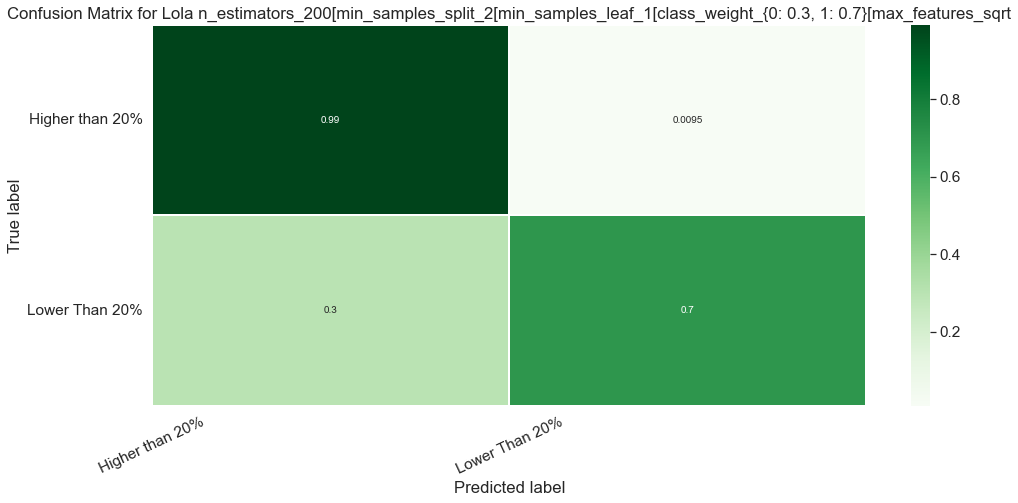

In [37]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.3, 1:.7},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
Score 0.9452185531589998
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
0.9452185531589998
[[4361   43]
 [ 244  591]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4404
           1       0.93      0.71      0.80       835

    accuracy                           0.95      5239
   macro avg       0.94      0.85      0.89      5239
weighted avg       0.94      0.95      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


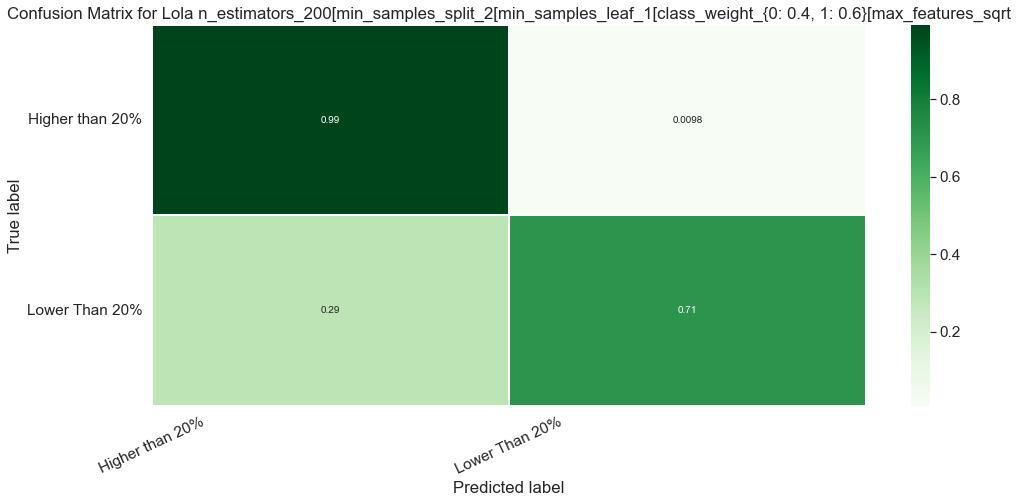

In [38]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.4, 1:.6},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: Lola n_estimators_300[min_samples_split_2[min_samples_leaf_3[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
Training model Lola n_estimators_300[min_samples_split_2[min_samples_leaf_3[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
Score 0.9259400648978813
Evaluating model Lola n_estimators_300[min_samples_split_2[min_samples_leaf_3[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
upload complete (model)
0.9259400648978813
[[4305   57]
 [ 331  546]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4362
           1       0.91      0.62      0.74       877

    accuracy                           0.93      5239
   macro avg       0.92      0.80      0.85      5239
weighted avg       0.92      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


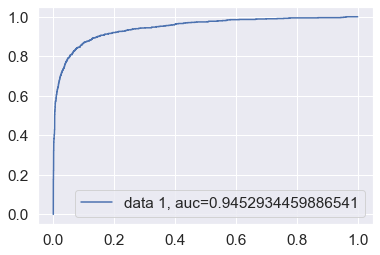

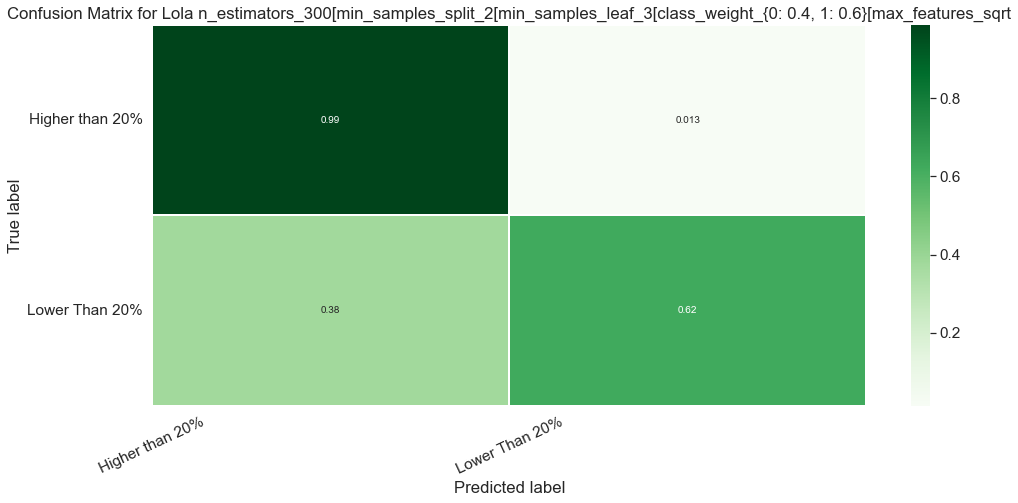

In [74]:
pars = {"n_estimators": 300,
 "min_samples_split": 3,
 "min_samples_leaf": 3,
"class_weight": {0:.4, 1:.6},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

created new ExperimentRun: Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Training model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.9373926321817141
Evaluating model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
upload complete (model)
0.9373926321817141
[[4281   81]
 [ 247  630]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4362
           1       0.89      0.72      0.79       877

    accuracy                           0.94      5239
   macro avg       0.92      0.85      0.88      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


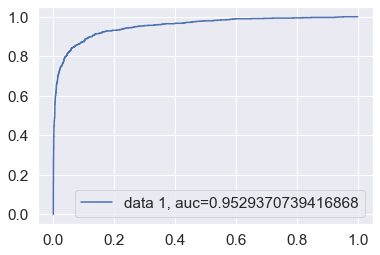

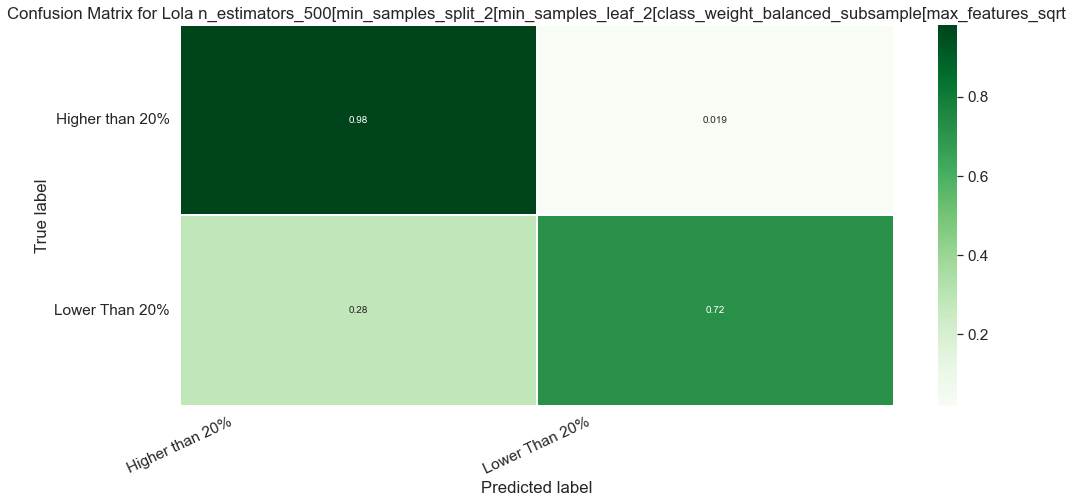

In [71]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
Training model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
Score 0.9381561366673029
Evaluating model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
upload complete (model)
0.9381561366673029
[[4287   75]
 [ 249  628]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4362
           1       0.89      0.72      0.79       877

    accuracy                           0.94      5239
   macro avg       0.92      0.85      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


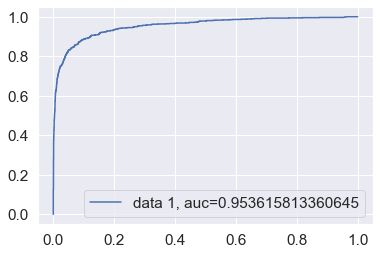

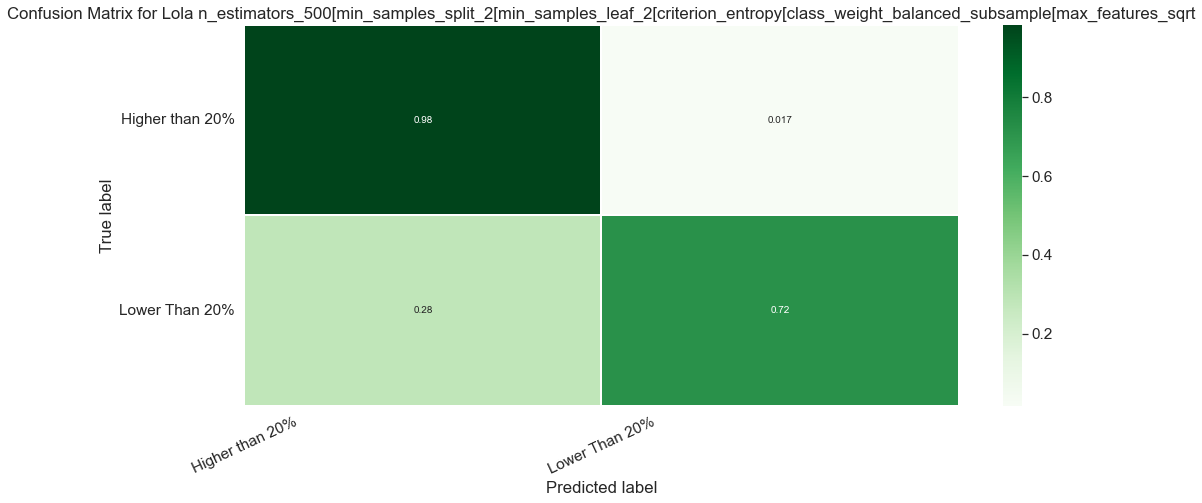

In [73]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"criterion": "entropy",
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

In [ ]:
# from sklearn.model_selection import GridSearchCV
# 
# parameters = {
# "n_estimators": 500,
# "min_samples_split": 2,
# "min_samples_leaf": 2,
# "criterion": "entropy",
# "class_weight": 'balanced_subsample',
# "max_features": "sqrt"
# }

In [79]:
y_train.value_counts()

label_20_up
0              39583
1               7566
dtype: int64

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import joblib
pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

y_train_1 = 7566
y_train_0 = 39583

hyperparameters_etG = {
"extratreesclassifier__n_estimators": (25, 75, 150, 250, 500),
"extratreesclassifier__criterion": ("gini", "entropy"),
"extratreesclassifier__max_depth": (25, 75, 150),
"extratreesclassifier__min_samples_split": (2, 5, 10, 20, 50),
"extratreesclassifier__min_samples_leaf": (1, 2, 3, 4, 5),
"extratreesclassifier__max_features": (0.2, 0.5, 0.8, 1),
"extratreesclassifier__bootstrap": (True, False),
"extratreesclassifier__class_weight": ('balanced', 
                                       {0: y_train_1, 1: y_train_0}, 
                                       {0: y_train_0, 1: y_train_1}),
"extratreesclassifier__max_samples": (0.2, 0.5, 0.8, 1)}
etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_etG,
                              n_jobs=5,
                              scoring='roc_auc',
                              verbose=6,
                              cv=5,
                              n_iter=200,
                              random_state=19)

In [12]:
et = ExtraTreesClassifier(random_state=19)

In [13]:
etG = et.fit(x_train, y_train)
joblib.dump(etG, "ET_BASED.pkl")

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_19996\2762527373.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  etG = et.fit(x_train, y_train)


['ET_BASED.pkl']

In [14]:
etG_rsCV = etG_rscv.fit(x_train, y_train)
joblib.dump(etG_rsCV, "ET_TUNED.pkl")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
440 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
440 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\ensemble\_forest.py", line 383

['ET_TUNED.pkl']

In [45]:
from model_factory import ModelFactory
_, y_class = ModelFactory.prepare_classification_label(df, -10)
y_class.value_counts()

2022-07-16 18:39:06,305 - root - INFO - Creating label column down_10_return with threshold of -10


KeyError: 'label_down_return'

In [17]:
etG_rsCV.best_params_

{'extratreesclassifier__n_estimators': 150,
 'extratreesclassifier__min_samples_split': 2,
 'extratreesclassifier__min_samples_leaf': 2,
 'extratreesclassifier__max_samples': 0.8,
 'extratreesclassifier__max_features': 0.8,
 'extratreesclassifier__max_depth': 75,
 'extratreesclassifier__criterion': 'gini',
 'extratreesclassifier__class_weight': {0: 7566, 1: 39583},
 'extratreesclassifier__bootstrap': True}

In [43]:
etG_rsCV.best_score_

0.941118033415566

In [ ]:
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)

In [46]:

pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, f"RAGE {'['.join(f'{k}_{v}' for k, v in pars.items())}")

NameError: name 'd_x_train' is not defined

In [47]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
_, y_class = ModelFactory.prepare_classification_label(df, 50)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model("GIGA", pars))

2022-07-16 18:39:08,486 - root - INFO - Creating label column up_50_return with threshold of 50


KeyError: 'label_up_return'

In [48]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
label_col, y_class = ModelFactory.prepare_classification_label(df, 80)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model(f"GIGA {label_col}", pars))

2022-07-16 18:39:09,241 - root - INFO - Creating label column up_80_return with threshold of 80


KeyError: 'label_up_return'

created new ExperimentRun: Lola n_estimators_150[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[max_depth_75[criterion_gini[class_weight_{0: 7566, 1: 39583}[bootstrap_True
Training model Lola n_estimators_150[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[max_depth_75[criterion_gini[class_weight_{0: 7566, 1: 39583}[bootstrap_True
Score 0.9286123305974423
Evaluating model Lola n_estimators_150[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[max_depth_75[criterion_gini[class_weight_{0: 7566, 1: 39583}[bootstrap_True
upload complete (model)
0.9286123305974423
[[4324   40]
 [ 334  541]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4364
           1       0.93      0.62      0.74       875

    accuracy                           0.93      5239
   macro avg       0.93      0.80      0.85      5239
weighted avg       0.93      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_19996\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


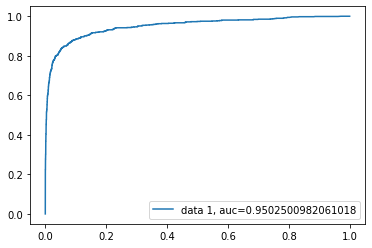

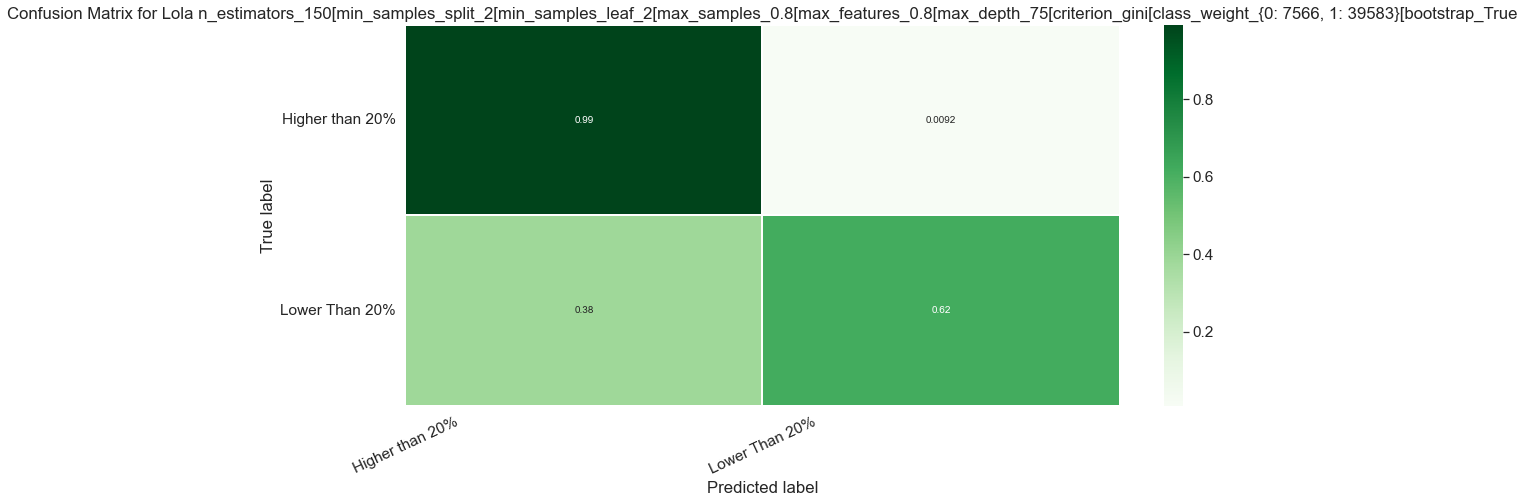

In [42]:
pars = {
'n_estimators': 150,
'min_samples_split': 2,
'min_samples_leaf': 2,
'max_samples': 0.8,
'max_features': 0.8,
'max_depth': 75,
'criterion': 'gini',
'class_weight': {0: 7566, 1: 39583},
'bootstrap': True
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

In [47]:
y_pred_proba = a1.predict_proba(x_test)[::,1]
roc_auc_score(y_test, y_pred_proba)

0.9502500982061018